In [25]:
# Run this in a notebook cell
import sys
print("Python executable:", sys.executable)
print("Python version:", sys.version)

Python executable: c:\Users\Dhruva Arekar\proj\bene\bene\Scripts\python.exe
Python version: 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]


In [26]:
# Run this in a notebook cell
import subprocess
result = subprocess.run([sys.executable, '-m', 'pip', 'list'], capture_output=True, text=True)
print("Installed packages containing 'g2p':")
for line in result.stdout.split('\n'):
    if 'g2p' in line.lower():
        print(line)

Installed packages containing 'g2p':
g2p-en                  2.1.0


In [27]:
# Run this in a notebook cell
import sys
import subprocess
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'g2p_en'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scipy'])

0

In [28]:
import nltk
import os

# Use a path without spaces
nltk_data_dir = 'C:/nltk_data'
os.makedirs(nltk_data_dir, exist_ok=True)

# Append to the existing path instead of replacing it
nltk.data.path.append(nltk_data_dir)

# Download to this location
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('averaged_perceptron_tagger', download_dir=nltk_data_dir)
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('cmudict', download_dir=nltk_data_dir)

[nltk_data] Downloading package punkt to C:/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package cmudict to C:/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


True

In [11]:
sessionNames = ['t12.2022.04.28',  't12.2022.05.26',  't12.2022.06.21',  't12.2022.07.21',  't12.2022.08.13',
't12.2022.05.05',  't12.2022.06.02',  't12.2022.06.23',  't12.2022.07.27',  't12.2022.08.18',
't12.2022.05.17',  't12.2022.06.07',  't12.2022.06.28',  't12.2022.07.29',  't12.2022.08.23',
't12.2022.05.19',  't12.2022.06.14',  't12.2022.07.05',  't12.2022.08.02',  't12.2022.08.25',
't12.2022.05.24',  't12.2022.06.16',  't12.2022.07.14',  't12.2022.08.11']
sessionNames.sort()

In [12]:
import re 
from g2p_en import G2p
import numpy as np

g2p = G2p()
PHONE_DEF = [
    'AA', 'AE', 'AH', 'AO', 'AW',
    'AY', 'B',  'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G',
    'HH', 'IH', 'IY', 'JH', 'K',
    'L', 'M', 'N', 'NG', 'OW',
    'OY', 'P', 'R', 'S', 'SH',
    'T', 'TH', 'UH', 'UW', 'V',
    'W', 'Y', 'Z', 'ZH'
]
PHONE_DEF_SIL = PHONE_DEF + ['SIL']

def phoneToId(p):
    return PHONE_DEF_SIL.index(p)

In [13]:
import scipy

def loadFeaturesAndNormalize(sessionPath):
    
    dat = scipy.io.loadmat(sessionPath)

    input_features = []
    transcriptions = []
    frame_lens = []
    block_means = []
    block_stds = []
    n_trials = dat['sentenceText'].shape[0]

    #collect area 6v tx1 and spikePow features
    for i in range(n_trials):    
        #get time series of TX and spike power for this trial
        #first 128 columns = area 6v only
        features = np.concatenate([dat['tx1'][0,i][:,0:128], dat['spikePow'][0,i][:,0:128]], axis=1)

        sentence_len = features.shape[0]
        sentence = dat['sentenceText'][i].strip()

        input_features.append(features)
        transcriptions.append(sentence)
        frame_lens.append(sentence_len)

    #block-wise feature normalization
    blockNums = np.squeeze(dat['blockIdx'])
    blockList = np.unique(blockNums)
    blocks = []
    for b in range(len(blockList)):
        sentIdx = np.argwhere(blockNums==blockList[b])
        sentIdx = sentIdx[:,0].astype(np.int32)
        blocks.append(sentIdx)

    for b in range(len(blocks)):
        feats = np.concatenate(input_features[blocks[b][0]:(blocks[b][-1]+1)], axis=0)
        feats_mean = np.mean(feats, axis=0, keepdims=True)
        feats_std = np.std(feats, axis=0, keepdims=True)
        for i in blocks[b]:
            input_features[i] = (input_features[i] - feats_mean) / (feats_std + 1e-8)

    #convert to tfRecord file
    session_data = {
        'inputFeatures': input_features,
        'transcriptions': transcriptions,
        'frameLens': frame_lens
    }

    return session_data

In [14]:
import os

def getDataset(fileName):
    session_data = loadFeaturesAndNormalize(fileName)
        
    allDat = []
    trueSentences = []
    seqElements = []
    
    for x in range(len(session_data['inputFeatures'])):
        allDat.append(session_data['inputFeatures'][x])
        trueSentences.append(session_data['transcriptions'][x])
        
        thisTranscription = str(session_data['transcriptions'][x]).strip()
        thisTranscription = re.sub(r'[^a-zA-Z\- \']', '', thisTranscription)
        thisTranscription = thisTranscription.replace('--', '').lower()
        addInterWordSymbol = True

        phonemes = []
        for p in g2p(thisTranscription):
            if addInterWordSymbol and p==' ':
                phonemes.append('SIL')
            p = re.sub(r'[0-9]', '', p)  # Remove stress
            if re.match(r'[A-Z]+', p):  # Only keep phonemes
                phonemes.append(p)

        #add one SIL symbol at the end so there's one at the end of each word
        if addInterWordSymbol:
            phonemes.append('SIL')

        seqLen = len(phonemes)
        maxSeqLen = 500
        seqClassIDs = np.zeros([maxSeqLen]).astype(np.int32)
        seqClassIDs[0:seqLen] = [phoneToId(p) + 1 for p in phonemes]
        seqElements.append(seqClassIDs)

    newDataset = {}
    newDataset['sentenceDat'] = allDat
    newDataset['transcriptions'] = trueSentences
    newDataset['phonemes'] = seqElements
    
    timeSeriesLens = []
    phoneLens = []
    for x in range(len(newDataset['sentenceDat'])):
        timeSeriesLens.append(newDataset['sentenceDat'][x].shape[0])
        
        zeroIdx = np.argwhere(newDataset['phonemes'][x]==0)
        phoneLens.append(zeroIdx[0,0])
    
    newDataset['timeSeriesLens'] = np.array(timeSeriesLens)
    newDataset['phoneLens'] = np.array(phoneLens)
    newDataset['phonePerTime'] = newDataset['phoneLens'].astype(np.float32) / newDataset['timeSeriesLens'].astype(np.float32)
    return newDataset

In [15]:
trainDatasets = []
testDatasets = []
competitionDatasets = []

dataDir = '../../competitionData'

for dayIdx in range(len(sessionNames)):
    print(dayIdx)
    trainDataset = getDataset(dataDir + '/train/' + sessionNames[dayIdx] + '.mat')
    testDataset = getDataset(dataDir + '/test/' + sessionNames[dayIdx] + '.mat')

    trainDatasets.append(trainDataset)
    testDatasets.append(testDataset)

    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        dataset = getDataset(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat')
        competitionDatasets.append(dataset)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [16]:
competitionDays = []
for dayIdx in range(len(sessionNames)):
    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        competitionDays.append(dayIdx)
print(competitionDays)

[4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20]


In [17]:
import pickle

allDatasets = {}
allDatasets['train'] = trainDatasets
allDatasets['test'] = testDatasets
allDatasets['competition'] = competitionDatasets

In [18]:
trainDatasets[0]['sentenceDat'][10].shape

(591, 256)

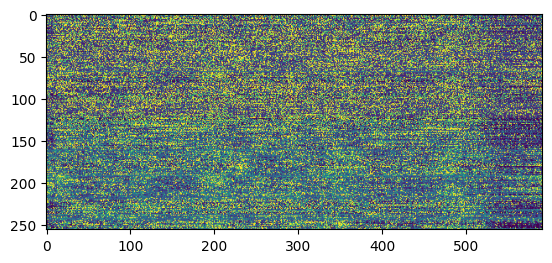

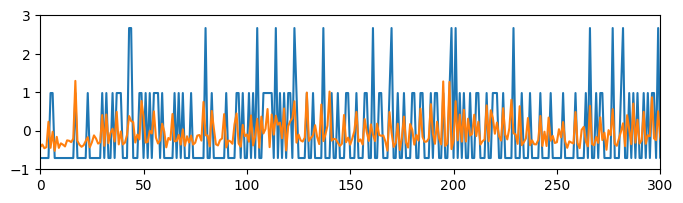

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(trainDatasets[0]['sentenceDat'][10][:, :].T, clim=[-1,1])
plt.show()

plt.figure(figsize=(8,2))
plt.plot(trainDatasets[0]['sentenceDat'][10][:,0])
plt.plot(trainDatasets[0]['sentenceDat'][10][:,128])
plt.xlim([0,300])
plt.ylim([-1,3])
plt.show()

In [20]:
trainDatasets[0].keys()

dict_keys(['sentenceDat', 'transcriptions', 'phonemes', 'timeSeriesLens', 'phoneLens', 'phonePerTime'])

## Model Inference

In [21]:
import sys
import os

# You're in: c:\Users\Dhruva Arekar\proj\bene\src\neural_encoder
# You need:  c:\Users\Dhruva Arekar\proj\bene\src

# Go up one level to get to src
parent_dir = os.path.dirname(os.getcwd())  # This gets you to src
print(f"Parent directory (src): {parent_dir}")

# Add src to path
sys.path.insert(0, parent_dir)

from neural_decoder.neural_decoder_trainer import loadModel

# Load the best model
modelDir = '../../logs/speech_logs/speechBaseline4'
model = loadModel(modelDir, device='cpu')
model.eval()  # Set to evaluation mode

Parent directory (src): c:\Users\Dhruva Arekar\proj\bene\src


c:\Users\Dhruva Arekar\proj\bene\bene\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


GRUDecoder(
  (inputLayerNonlinearity): Softsign()
  (unfolder): Unfold(kernel_size=(32, 1), dilation=1, padding=0, stride=4)
  (gaussianSmoother): GaussianSmoothing()
  (gru_decoder): GRU(8192, 1024, num_layers=5, batch_first=True, dropout=0.4, bidirectional=True)
  (inpLayer0): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer1): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer2): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer3): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer4): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer5): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer6): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer7): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer8): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer9): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer10): Linear(in_features=256, out_features=2

In [22]:
import torch

num_found = 0
trial_idx = 0
phones = np.array(["BLANK"] + PHONE_DEF_SIL)
BENEDICT = {}
while num_found < 41:
    neural_data = trainDatasets[0]['sentenceDat'][trial_idx]  # Shape: (time_steps, 256)
    # Convert to tensor and add batch dimension
    X = torch.tensor(neural_data, dtype=torch.float32).unsqueeze(0)  # Shape: (1, time_steps, 256)

    # You also need the day index for the model
    dayIdx = torch.tensor([0], dtype=torch.int64)  # Day 0 for first training dataset

    with torch.no_grad():  # Disable gradient computation for inference
        # Forward pass through the model
        logits = model.forward(X, dayIdx)

        # Apply log softmax to get log probabilities
        log_probs = logits.log_softmax(2)

    decoded_phones = phones[np.argmax(np.exp(log_probs[0]), axis = 1)]

    phone_to_time = []
    for i in range(len(decoded_phones)):
        phone_to_time.append([decoded_phones[i], i*4, (i+1)*4])

    prev = phone_to_time[0][0]
    phone_to_time_adjusted = [phone_to_time[0]]
    for elem in phone_to_time[1:]:
        phone, end = elem[0], elem[2]
        if phone == prev:
            phone_to_time_adjusted[-1][2] = end
        else:
            phone_to_time_adjusted.append(elem)
            prev = phone

    for elem in phone_to_time_adjusted:
        phone, start, end = elem
        if phone not in BENEDICT:
            actual_end = min(end, neural_data.shape[0])
            neural_slice = neural_data[start:actual_end]

            if neural_slice.shape[0] > 0:
                BENEDICT[phone] = neural_slice

    num_found = len(BENEDICT)
    print(num_found)
    trial_idx += 1

c:\Users\Dhruva Arekar\proj\bene\src\neural_decoder\augmentations.py:91: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return self.conv(input, weight=self.weight, groups=self.groups, padding="same")
C:\Users\Dhruva Arekar\AppData\Local\Temp\ipykernel_26860\2333617370.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  decoded_phones = phones[np.argmax(np.exp(log_probs[0]), axis = 1)]


22
28
33
34
37
37
37
37
37
37
39
39
39
40
40
40
40
40
40
41


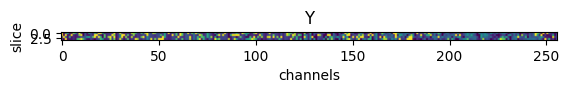

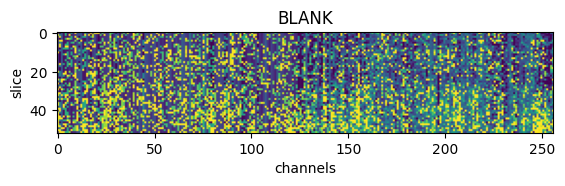

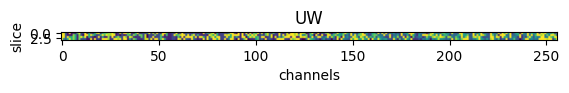

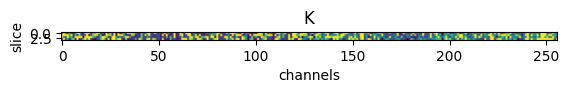

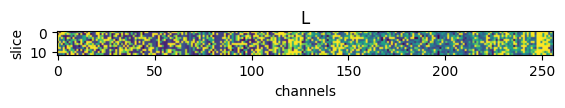

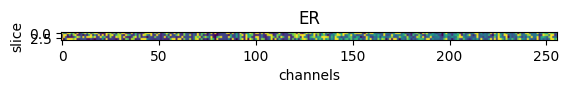

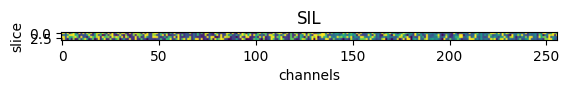

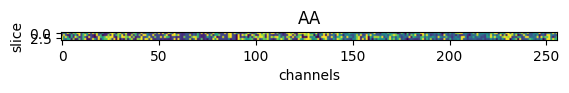

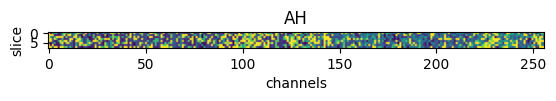

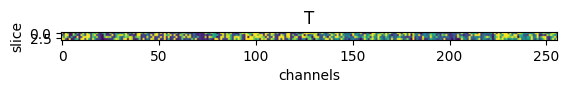

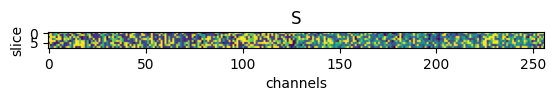

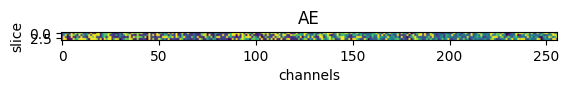

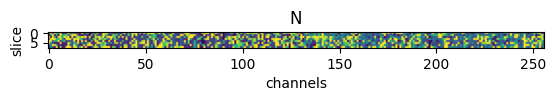

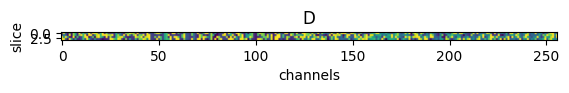

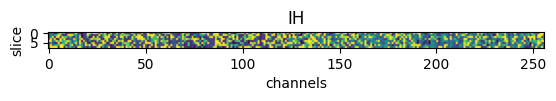

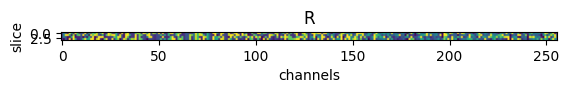

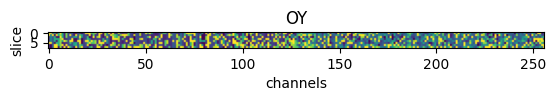

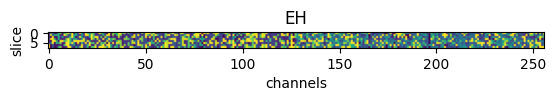

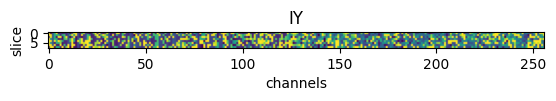

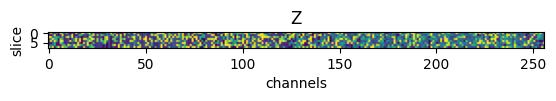

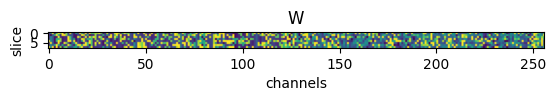

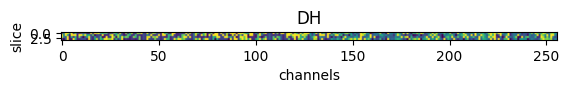

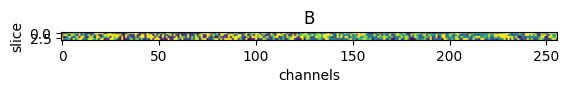

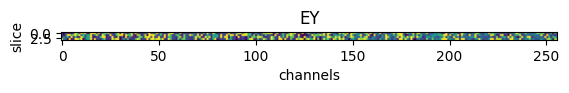

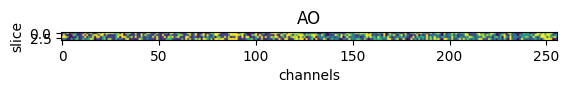

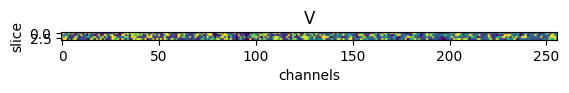

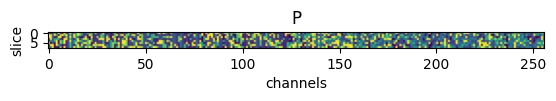

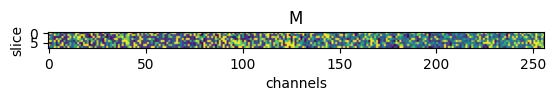

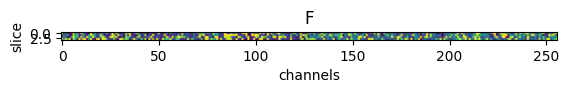

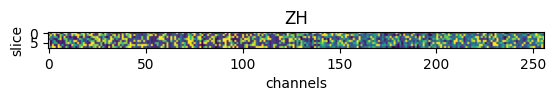

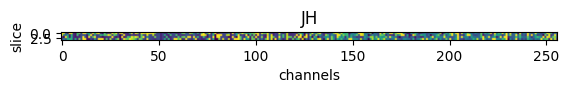

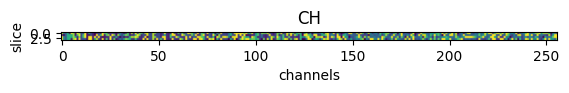

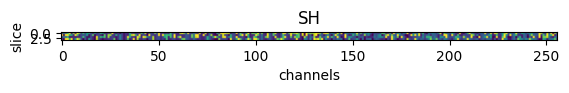

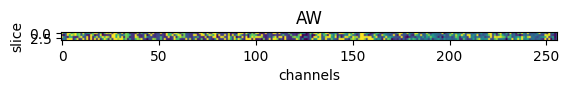

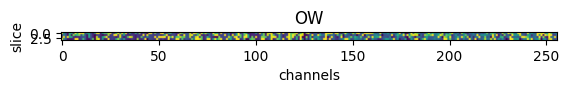

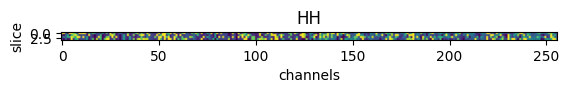

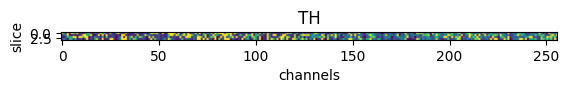

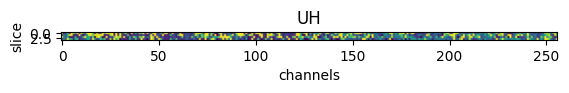

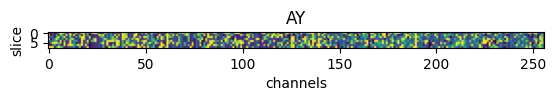

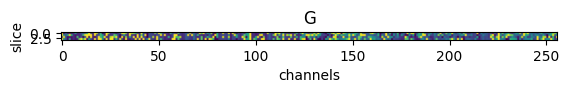

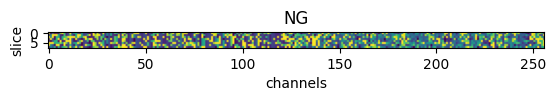

In [23]:
for phone, signal in BENEDICT.items():
    plt.imshow(signal, clim=[-1,1])
    plt.title(f"{phone}")
    plt.ylabel("slice")
    plt.xlabel("channels")
    plt.show()

(104, 256)


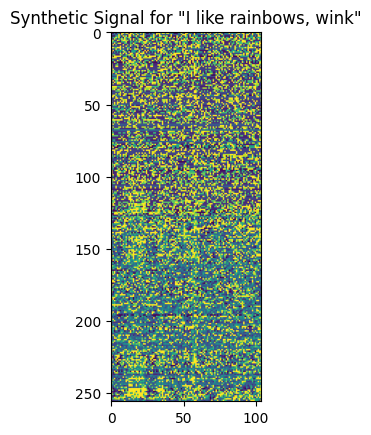

In [66]:
# Text to signal
from g2p_en import G2p

g2p = G2p()
INPUT_TEXT = 'I like rainbows wink'
phones = g2p(INPUT_TEXT)
phones_clean = [p.rstrip("012") for p in phones]
snips = []

for p in phones_clean:
    if p == ' ':
        p = "SIL"
    snips.append(BENEDICT[p])

synthetic = np.concatenate(snips, axis=0)

plt.imshow(synthetic.T, clim=[-1,1])
plt.title("Synthetic Signal for \"I like rainbows, wink\"")
print(np.shape(synthetic))


In [67]:
# Decode the synthetic
X = torch.tensor(synthetic, dtype=torch.float32).unsqueeze(0)  # Shape: (1, time_steps, 256)
dayIdx = torch.tensor([0], dtype=torch.int64)  # Day 0 for first training dataset
with torch.no_grad():  # Disable gradient computation for inference
    # Forward pass through the model
    logits = model.forward(X, dayIdx)

    # Apply log softmax to get log probabilities
    log_probs = logits.log_softmax(2)

    print(f"Logits shape: {logits.shape}")  # Should be (batch, seq_len, n_classes+1)
    print(f"Log probabilities shape: {log_probs.shape}")

phones = np.array(["BLANK"] + PHONE_DEF_SIL)
decoded_phones = phones[np.argmax(np.exp(log_probs[0]), axis = 1)]
print(decoded_phones)

Logits shape: torch.Size([1, 19, 41])
Log probabilities shape: torch.Size([1, 19, 41])
['L' 'BLANK' 'AA' 'K' 'K' 'BLANK' 'BLANK' 'BLANK' 'BLANK' 'IY' 'N' 'BLANK'
 'BLANK' 'BLANK' 'BLANK' 'BLANK' 'BLANK' 'BLANK' 'BLANK']


C:\Users\Dhruva Arekar\AppData\Local\Temp\ipykernel_26860\3852553145.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  decoded_phones = phones[np.argmax(np.exp(log_probs[0]), axis = 1)]
